# NIHCXR Synthetic Drift - Gaussian Shift

## Load Libraries

In [1]:
from drift_detection.drift_detector import (
    Detector,
    Experimenter,
    Reductor,
    SyntheticShiftApplicator,
    TSTester,
    plot_drift_samples_pval,
)
from drift_detection.datasets import NIHCXRDataset
from drift_detection.drift_detector.utils import Loader

2022-11-11 08:38:13.142964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 08:38:13.142981: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Query Data

In [2]:
# Load the dataset
dataset = NIHCXRDataset(cfg_path="../../datasets/configs/nihcxr.yaml")
dataset, metadata, metadata_mapping = dataset.get_data()

Setting XRayResizer engine to cv2 could increase performance.


## Initalize Reductor, Tester & Detector

In [3]:
reductor = Reductor(
    dr_method="TAE_txrv_CNN",
)

tester = TSTester(
    tester_method="mmd",
)


detector = Detector(
    reductor=reductor,
    tester=tester,
)
with Loader("Initializing the detector..."):
    detector.fit(dataset, progress=False)

Initializing the detector... ⣻

2022-11-11 08:38:25.603931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 08:38:25.604622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akore/.cache/pypoetry/virtualenvs/cyclops-4J2PL5I8-py3.9/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-11 08:38:25.604687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akore/.cache/pypoetry/virtualenvs/cyclops-4J2PL5I8-py3.9/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-11 08:38:25.604735: W tensorflow/stream_executor/platform/defaul

Done!                                                                           


## Setup Baseline Experiment

In [4]:
baseline_experiment = Experimenter(
    "sensitivity_test",
    detector=detector,
)

## Setup Drift Experiment (Categorical Shift)

In [5]:
shiftapplicator = SyntheticShiftApplicator(
    shift_type="gn_shift",
)

drift_experiment = Experimenter(
    "sensitivity_test",
    detector=detector,
    shiftapplicator=shiftapplicator,
)

## Run Experiments

In [6]:
baseline_results = baseline_experiment.run(dataset, metadata, metadata_mapping)
drift_results = drift_experiment.run(dataset, metadata, metadata_mapping)

100%|██████████| 35/35 [00:46<00:00,  1.33s/it]


## Gather Results

In [7]:
results = {"baseline": baseline_results, "gaussian_noise": drift_results}

## Plot Experimental Results

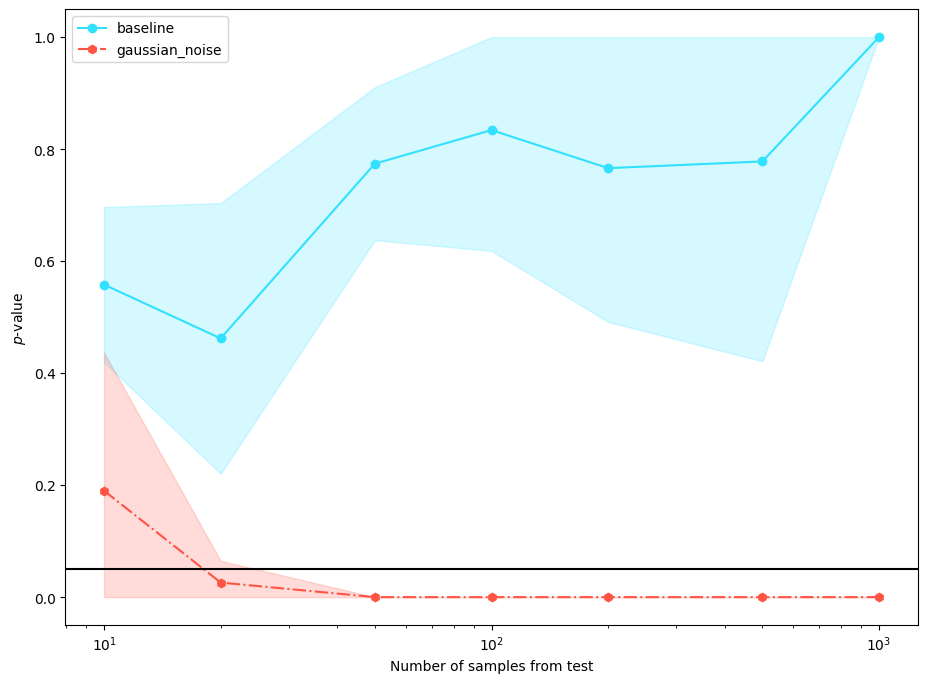

In [8]:
plot_drift_samples_pval(results, 0.05)